APPROACH THAT WE USED IN THIS RESEARCH

In [1]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
train_dir = "../data/final/train"
test_dir  = "../data/final/test"

img_size = (224, 224)
batch_size = 16

image_files = [f for f in os.listdir(train_dir) if f.endswith(".tif")]


class_labels = sorted(set(f.split("_")[0] for f in image_files))
class_to_index = {label: i for i, label in enumerate(class_labels)}

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse', color_mode='rgb'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False  
)

Found 9252 images belonging to 257 classes.
Found 514 images belonging to 257 classes.


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-16]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                 
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_fingerprint_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

model.save("best_fingerprint_model.h5")
print("\nModel trained and saved as best_fingerprint_model.h5")

Epoch 1/100
579/579 [==============================] - ETA: 0s - loss: 7.1448 - accuracy: 0.0044
Epoch 1: val_accuracy improved from -inf to 0.00584, saving model to best_fingerprint_model.h5
579/579 [==============================] - 118s 176ms/step - loss: 7.1448 - accuracy: 0.0044 - val_loss: 6.9749 - val_accuracy: 0.0058 - lr: 1.0000e-05
Epoch 2/100
579/579 [==============================] - ETA: 0s - loss: 6.8597 - accuracy: 0.0072
Epoch 2: val_accuracy improved from 0.00584 to 0.01946, saving model to best_fingerprint_model.h5
579/579 [==============================] - 98s 169ms/step - loss: 6.8597 - accuracy: 0.0072 - val_loss: 6.6593 - val_accuracy: 0.0195 - lr: 1.0000e-05
Epoch 3/100
579/579 [==============================] - ETA: 0s - loss: 6.5393 - accuracy: 0.0237
Epoch 3: val_accuracy improved from 0.01946 to 0.07782, saving model to best_fingerprint_model.h5
579/579 [==============================] - 98s 169ms/step - loss: 6.5393 - accuracy: 0.0237 - val_loss: 6.1855 - va

In [4]:
print(test_gen.class_indices)

{'001_1': 0, '001_2': 1, '001_3': 2, '001_4': 3, '001_5': 4, '001_6': 5, '002_10': 6, '002_11': 7, '002_12': 8, '002_7': 9, '002_8': 10, '002_9': 11, '003_13': 12, '003_14': 13, '003_15': 14, '003_16': 15, '003_17': 16, '003_18': 17, '004_19': 18, '004_20': 19, '004_21': 20, '004_22': 21, '004_23': 22, '004_24': 23, '005_25': 24, '005_26': 25, '005_27': 26, '005_28': 27, '005_29': 28, '005_30': 29, '006_31': 30, '006_32': 31, '006_33': 32, '006_34': 33, '006_35': 34, '006_36': 35, '007_37': 36, '007_38': 37, '007_39': 38, '007_40': 39, '007_41': 40, '007_42': 41, '008_43': 42, '008_44': 43, '008_45': 44, '009_46': 45, '009_47': 46, '009_48': 47, '009_49': 48, '009_50': 49, '009_51': 50, '010_52': 51, '010_53': 52, '010_54': 53, '010_55': 54, '010_56': 55, '010_57': 56, '010_58': 57, '010_59': 58, '010_60': 59, '010_61': 60, '011_62': 61, '011_63': 62, '011_64': 63, '011_65': 64, '011_66': 65, '011_67': 66, '011_68': 67, '011_69': 68, '011_70': 69, '011_71': 70, '012_72': 71, '012_73': 

In [5]:
model = load_model("best_fingerprint_model.h5")

loss, accuracy = model.evaluate(test_gen)
print(f"\n Test Loss: {loss:.4f}")
print(f" Test Accuracy: {accuracy:.4f}")

33/33 [==============================] - 2s 53ms/step - loss: 1.5292 - accuracy: 0.9163

 Test Loss: 1.5292
 Test Accuracy: 0.9163


In [6]:
X_test = []
y_test = []

steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

for i in range(steps):
    x, y = next(test_gen)
    X_test.append(x)
    y_test.append(y)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_probs = model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

33/33 [==============================] - 2s 51ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    0.5000    0.6667         2
         1.0     1.0000    1.0000    1.0000         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    1.0000    1.0000         2
         4.0     1.0000    1.0000    1.0000         2
         5.0     1.0000    0.5000    0.6667         2
         6.0     0.6667    1.0000    0.8000         2
         7.0     1.0000    1.0000    1.0000         2
         8.0     1.0000    1.0000    1.0000         2
         9.0     1.0000    1.0000    1.0000         2
        10.0     1.0000    1.0000    1.0000         2
        11.0     1.0000    1.0000    1.0000         2
        12.0     0.6667    1.0000    0.8000         2
        13.0     1.0000    1.0000    1.0000         2
        14.0     1.0000    1.0000    1.0000         2
        15.0     0.5000    0.5000    0.5000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 18ms/step


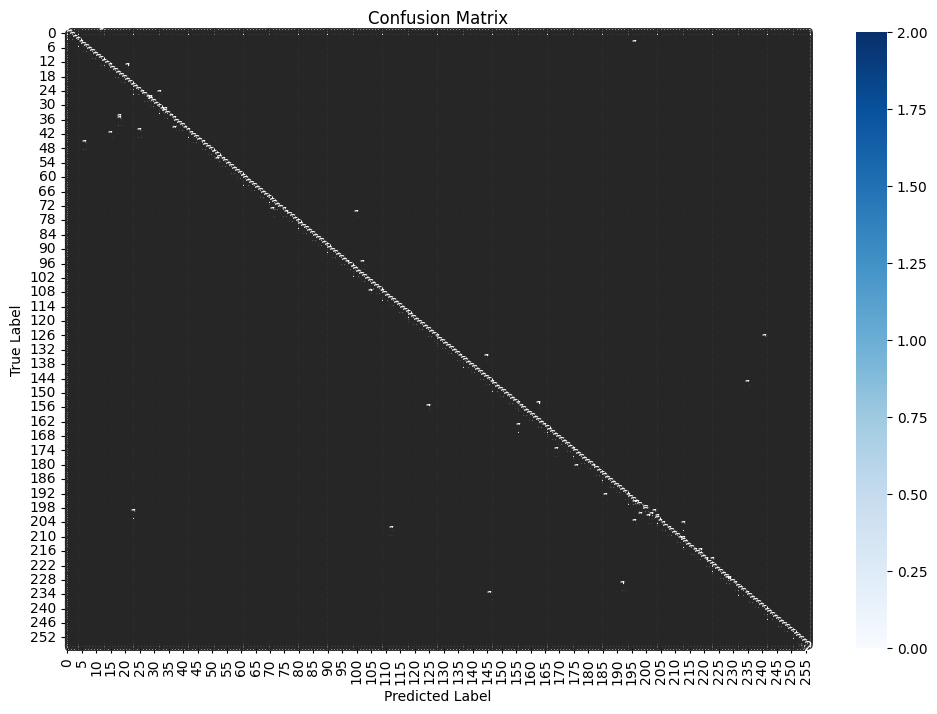

In [7]:
y_true = []
y_pred = []

test_gen.reset()
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_gen)

    if y_batch.ndim > 1:
        y_true.extend(np.argmax(y_batch, axis=1))
    else:
        y_true.extend(y_batch)

    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [8]:
report = classification_report(y_test, y_pred, output_dict=True)

precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

print(f"\nMacro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")


Macro Avg - Precision: 0.9361, Recall: 0.9163, F1 Score: 0.9104
Weighted Avg - Precision: 0.9361, Recall: 0.9163, F1 Score: 0.9104


c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:

y_test_onehot = label_binarize(y_test, classes=np.arange(model.output_shape[-1]))
roc_auc = roc_auc_score(y_test_onehot, y_pred_probs, average='macro', multi_class='ovr')

print(f"ROC AUC Score (macro): {roc_auc:.4f}")

ROC AUC Score (macro): 0.9980
